# Pryngles module: Spangler

This module contains all the physics of light scattered on spangles

In [2]:
from pryngles import *

## External modules

In [3]:
import pandas as pd
from collections import OrderedDict as odict
from copy import deepcopy
import random

#Aliases
print_df=Misc.print_df
sci=Science
verbose=Verbose.print

## The Spangler class

This class contains a family of routines useful for spangling different kind of objects.

In [85]:
Spangler_doc=\
"""A Spangler associated to an object or set of objects.
    
   There are two ways to initialize a Spangler:
    
        Creating a Spangler for a single object:

            nspangles: int, default = 0:
                Number of spangles in spangling.

            body_hash: string, default = None:
                Hash identifying the body to which spangles are associated 
                (see Body documentation for explanation about hash).
                
            spangle_type: int, default = 0:
                Type of spangle (see *_SPANGLE in Consts module).

            n_equ: numpy Array (3), default = [0,0,1]:
                unitary vector normal to {equ} (equatorial) plane.
        
        Joining a set of Spanglers (several objects):

            spanglers: list of Spanglers. default = []:
                Set of spanglers to join.
                
            n_obs: numpy Array (3), default = [0,0,1]:
                unitary vector normal to {obs} observer direction.
            
Core attributes:

    nspangles: int:
        Total number of spangles.

    data: Pandas DataFrame: 
        Dataframe containing all the information about the spangling.
        For Columns see global variable SPANGLER_COLUMNS.

            
Secondary attributes:

    M_ecl2obs, M_obs2ecl: array (3x3):
        Transformation matrices going from {obs} <-> {ecl}.

    M_ecl2equ, M_equ2ecl: array (nspanglersx3x3):
        Transformation matrices going from {equ} <-> {ecl}.
        
Public methods:
    
    update_positions: update positions by changing observer orientation.
"""

In [86]:
#Columns of spangling
SPANGLER_COLUMNS=odict(
    {
        "body_hash":"",
        
        #Type of spangle
        "type":SOLID_SPANGLE,#For a list of spangle types see the constants module.
        
        #Lengh-scale
        "scale":1,#The length scale of the body, eg. for a ring this is the outer radius
        
        #Coordinates of the spangle (cartesian and spherical) in the ecliptic system
        "center":[0,0,0],#Center of the body with respect to barycenter
        "x_ecl":0,"y_ecl":0,"z_ecl":0,#Calculated in the class
        "r_ecl":0,"t_ecl":0,"f_ecl":0,#Calculated in the class
        "ns_ecl":[0,0,0],#Unitary vector normal to the spangle, calculated in the class

        #Coordinates of the spangle (cartesian and spherical) in the observer system
        "n_obs":[0,0,1],#Direction of the observer, provided 
        "alpha_obs":0,#Zero meridian of observer system
        "x_obs":0,"y_obs":0,"z_obs":0,#Calculated in the class
        "r_obs":0,"t_obs":0,"f_obs":0,#Calculated in the class
        "ns_obs":[0,0,0],#Unitary vector normal to the spangle, calculated in the class
        
        #Coordinates of the spangle (cartesian and spherical) in the light-source system
        "n_luz":[0,0,1],#Direction of the light-source, provided
        "alpha_luz":0,#Zero meridian of observer system
        "x_luz":0,"y_luz":0,"z_luz":0,#Calculated in the class
        "r_luz":0,"t_luz":0,"f_luz":0,#Calculated in the class
        "ns_luz":[0,0,0],#Unitary vector normal to the spangle, calculated in the class

        #Coordinates of the spangle (cartesian and spherical) in the body-centric system
        "n_equ":[0,0,1],#Direction of the equator
        "alpha_equ":0,#Zero meridian of equatorial system
        "x_equ":0,"y_equ":0,"z_equ":1,
        "r_equ":0,"t_equ":0,"f_equ":90*Consts.deg,
        "ns_equ":[0,0,1],#Unitary vector normal to the spangle
        
        #Rotational parameteres, t = t0 + w (T - T0)
        "w_equ":0,#Rotational angular velocity
        "t0_equ":0,#Initial longitude 
        "T0_equ":0,#Initial time
        
        #Geometrical parameters
        "asp":1.0, #Area of the spangle
        "dsp":1.0, #Effective diameter of spangle, dsp = 2*(asp/pi)**0.5
        
        #Optical parameters
        "albedo_gray_normal":1,
        "tau_gray_optical":0.0,
        
        #Spangle state
        "unset":1, #State has not been set
        "visible":0, #The spangle is visible from observer
        "shadow":0, #The spangle is in the shadow of other spangle
        "illuminated":0, #The spangle is illuminated by the light-source
        "transit":0, #The spangle is transiting
        "indirect":0, #The spangle is indirectly illuminated
        "occult":0, #The spangle is occulted by a light source
        "emit":0, #The spangle is emmitting
    }
)

In [87]:
class Spangler(PrynglesCommon):
    
    def __init__(self,
                 #Initialization using specific options
                 nspangles=1,
                 body_hash=None,
                 spangle_type=SOLID_SPANGLE,
                 n_equ=SPANGLER_COLUMNS["n_equ"],
                 center=SPANGLER_COLUMNS["center"],
                 #Initialization with a list of 
                 spanglers=[],
                 n_obs=SPANGLER_COLUMNS["n_obs"]):

        #Create a spanglers with a list of other spanglers
        if len(spanglers)>0:
            self._join_spanglers(spanglers,n_obs=n_obs)
            
        #Create a spangler with the desired options
        else:
            #Attributes
            self.nspangles=nspangles
            
            #Update default values
            self._defaults=deepcopy(SPANGLER_COLUMNS)

            if not body_hash:
                body_hash=str(random.getrandbits(16))
            self._defaults.update(dict(body_hash=body_hash))
            if spangle_type:
                self._defaults.update(dict(type=spangle_type))

            #Create Spangler dataframe
            if self.nspangles>0:
                
                #Create a simple DataFrame with the default values
                self.data=pd.DataFrame([list(self._defaults.values())]*self.nspangles,columns=self._defaults.keys())

                #Update positions
                self.set_positions(n_equ=n_equ,n_obs=n_obs,center=center)
        
            else:        
                #Creat a blank DataFrame
                self.data=pd.DataFrame(columns=self._defaults.keys())
                
    # Prototype
    def _join_spanglers(self,spanglers,nobs):pass
    
Spangler.__doc__=Spangler_doc

In [88]:
def set_observer(self,n_obs=[],alpha_obs=0,force=False):
    """
    Set the positions and orientation of spanglers in the observer system.

    Parameters:

        n_obs: list/array (3), default = []:
            Normal vector towards the observer.

    Optional:

        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    Return:
        None

    Update:

        Coordinates of the spangles, (x_obs,y_obs,z_obs) and their spherical 
        counterparts (r_obs,t_obs,f_obs).

        Normal to spangles, ns_obs.

        Rotation matrices M_ecl2obs, M_obs2ecl, 
    """

    if len(n_obs)>0:
        #Unitary observer vector
        n_obs,one=spy.unorm(n_obs)
        self.data["n_obs"]=self.data.apply(lambda df:n_obs,axis=1)

        #Observer direction in spherical coordinates
        self.d_obs=sci.xyz2rtf(n_obs)

        #Transformation matrices
        ez_obs=n_obs
        ex_obs=spy.ucrss([0,0,1],n_obs) #Spice is 5 faster for vcrss
        if spy.vnorm(ex_obs)==0:
            ex_obs=np.array([1,0,0]) if np.sum(ez_obs)>0 else np.array([-1,0,0])
        ey_obs=spy.ucrss(ez_obs,ex_obs)
        self.M_obs2ecl=np.array(list(np.vstack((ex_obs,ey_obs,ez_obs)).transpose())).reshape((3,3))
        self.M_ecl2obs=spy.invert(self.M_obs2ecl)
        verbose("Axis obs:",ex_obs,ey_obs,ez_obs)
        self.axis_obs=[ex_obs,ey_obs,ez_obs]

    #Update positions
    #Use: df[["a","b","c"]]=[np.matmul(M,x)+[0,1,0] for x in np.array(df[["x","y","z"]])] is 10 times faster
    self.data[["x_obs","y_obs","z_obs"]]=\
        self.data.apply(lambda df:pd.Series(np.matmul(self.M_ecl2obs,
                                                    [df.x_ecl,df.y_ecl,df.z_ecl])),
                        axis=1)
    
    self.data[["r_obs","t_obs","f_obs"]]=\
        self.data.apply(lambda df:pd.Series(sci.xyz2rtf([df.x_obs,df.y_obs,df.z_obs])),
                        axis=1)

    #Update spangles orientations
    self.data["ns_obs"]=self.data.apply(lambda df:np.matmul(self.M_ecl2obs,df["ns_ecl"]),axis=1)

Spangler.set_observer=set_observer

In [104]:
def set_positions(self,
                  n_equ=[],alpha_equ=0,
                  n_obs=[],alpha_obs=0,
                  center=[],
                  T=0
                 ):
    """
    Set the positions and orientation of spanglers in all reference systems.

    Parameters:

        n_equ: list/array (3), default = []:
            Normal vector towards north pole equatorial system.

        n_obs: list/array (3), default = []:
            Normal vector towards the observer.
            
        center: list/array (3), default = []:
            Location of the center of the body with respect to the barycenter.
            
        T: float, default = 0:
            Time.  This quantity is used to update the equatorial coordinates.

    Optional:

        alpha_equ: float, default = 0:
            Roll angle of x-axis of equatorial system (not implemented yet)

        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    Return:
        None

    Update:

        Coordinates of the spangles, (X_ecl,Y_ecl,Z_ecl) and their spherical 
        counterparts (R_ecl,T_ecl,F_ecl) with respect to the barycenter.

        Coordinates of the spangles, (x_ecl,y_ecl,z_ecl) and their spherical 
        counterparts (r_ecl,t_ecl,f_ecl) with respect to the body center.

        Coordinates of the spangles, (x_obs,y_obs,z_obs) and their spherical 
        counterparts (r_obs,t_obs,f_obs).

        Normal to spangles, ns_equ, ns_ecl, ns_obs.

        Rotation matrices M_equ2ecl
    """
    
    if len(n_equ)>0:
        #Unitary equatorial vector
        n_equ,one=spy.unorm(n_equ)
        self.data["n_equ"]=self.data.apply(lambda df:n_equ,axis=1)

        #Transformation matrices
        ez_equ=n_equ
        ex_equ=spy.ucrss([0,0,1],n_equ)
        if spy.vnorm(ex_equ)==0:
            ex_equ=np.array([1,0,0]) if np.sum(ez_equ)>0 else np.array([-1,0,0])
        ey_equ=spy.ucrss(ez_equ,ex_equ)
        
        self.M_equ2ecl=np.array(list(np.vstack((ex_equ,ey_equ,ez_equ)).transpose())).reshape((3,3))
        self.M_ecl2equ=spy.invert(self.M_equ2ecl)
        self.axis_equ=[ex_equ,ey_equ,ez_equ]
        verbose("Axis equ:",ex_equ,ey_equ,ez_equ)
     
    #Update equatorial coordinates by rotation
    """
    #Not implemented yet
    self.data["t_equ"]=self.data.apply(lambda df:pd.Series(df.t0_equ+df.w_equ*(T-df.T0_equ)),axis=1)
    self.data[["x_equ","t_equ","f_equ"]]=\
        self.data.apply(lambda df:pd.Series(sci.rtf2xyz([df.r_equ,df.t_equ,df.f_equ])),
                        axis=1)
    """

    #Update spangles positions
    if len(center)>0:
        self.data["center"]=self.data.apply(lambda df:np.array(center),axis=1)
    self.data[["x_ecl","y_ecl","z_ecl"]]=\
        self.data.apply(lambda df:pd.Series(np.matmul(self.M_equ2ecl,
                                                    [df.x_equ,df.y_equ,df.z_equ])+df.center),
                        axis=1)

    self.data[["r_ecl","t_ecl","f_ecl"]]=\
        self.data.apply(lambda df:pd.Series(sci.xyz2rtf([df.x_ecl,df.y_ecl,df.z_ecl])),
                        axis=1)

    #Update spangles orientations
    self.data["ns_ecl"]=self.data.apply(lambda df:np.matmul(self.M_equ2ecl,np.array(df["ns_equ"])),axis=1)
    
    #Update velocities
    #Not implemented yet
    
    #Set observer
    self.set_observer(n_obs=n_obs)
    
Spangler.set_positions=set_positions

In [105]:
if IN_JUPYTER:
    def test_init(self):
        Verbose.VERBOSITY=1
        print("Basic definition:")
        sg=Spangler(nspangles=3,spangle_type=GRANULAR_SPANGLE,center=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Equ->Obs:\n",sg.M_obs2ecl)

        print("\nAnother definition:")
        sg=Spangler(nspangles=3,n_equ=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)

        print("\nDefinition observer:")
        sg=Spangler(nspangles=3,body_hash="123",n_equ=[0,1,0],n_obs=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)
        Verbose.VERBOSITY=0

    class Test(unittest.TestCase):pass
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Basic definition:
Axis equ: [1 0 0] [0. 1. 0.] [0. 0. 1.]
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]


,body_hash,type,scale,center,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,ns_ecl,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_obs,n_luz,alpha_luz,x_luz,y_luz,z_luz,r_luz,t_luz,f_luz,ns_luz,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,ns_equ,w_equ,t0_equ,T0_equ,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit
0,17946,1,1,"[1, 0, 0]",1.0,0.0,1.0,1.414214,0.0,0.785398,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,1.0,0.0,1.0,1.414214,0.0,0.785398,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0
1,17946,1,1,"[1, 0, 0]",1.0,0.0,1.0,1.414214,0.0,0.785398,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,1.0,0.0,1.0,1.414214,0.0,0.785398,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0
2,17946,1,1,"[1, 0, 0]",1.0,0.0,1.0,1.414214,0.0,0.785398,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,1.0,0.0,1.0,1.414214,0.0,0.785398,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0


Equ->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Equ->Obs:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Another definition:
Axis equ: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]


,body_hash,type,scale,center,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,ns_ecl,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_obs,n_luz,alpha_luz,x_luz,y_luz,z_luz,r_luz,t_luz,f_luz,ns_luz,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,ns_equ,w_equ,t0_equ,T0_equ,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit
0,38870,0,1,"[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[1.0, 0.0, 0.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0
1,38870,0,1,"[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[1.0, 0.0, 0.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0
2,38870,0,1,"[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[1.0, 0.0, 0.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0


Equ->Ecl:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Obs->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Definition observer:
Axis equ: [-1.  0.  0.] [ 0. -0.  1.] [0. 1. 0.]
Axis obs: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]


,body_hash,type,scale,center,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,ns_ecl,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_obs,n_luz,alpha_luz,x_luz,y_luz,z_luz,r_luz,t_luz,f_luz,ns_luz,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,ns_equ,w_equ,t0_equ,T0_equ,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit
0,123,0,1,"[0, 0, 0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 1.0, 0.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0
1,123,0,1,"[0, 0, 0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 1.0, 0.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0
2,123,0,1,"[0, 0, 0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 1.0, 0.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0


.

Equ->Ecl:
 [[-1.  0.  0.]
 [ 0. -0.  1.]
 [ 0.  1.  0.]]
Obs->Ecl:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]



----------------------------------------------------------------------
Ran 1 test in 0.075s

OK


In [106]:
def populate_spangler(self,scale=1,seed=0,geometry="circle",**geometry_args):
    """Populate data of a Spangler using points generated with a given geometry.
    
    Parameters:
    
        geometry: string, default = "circle":
            Geometry of the Sampler.  Available: "circle", "ring", "sphere"
            
            
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangle will be always the same.
    """
    #Create sampler
    self.sample=Sampler(N=self.nspangles,seed=seed)
    self.geometry=geometry
    
    #Generate sampling points
    exec(f"self.sample.gen_{geometry}(**geometry_args)")
    
    #Purge sample if it is in 3d
    if self.sample.dim>2:
        verbose("Purging sample")
        self.sample.purge_sample()
                
    #Check if number of samples is not equal to that of spangles
    if self.sample.N!=self.nspangles:
        dif=self.sample.N-self.nspangles
        if dif>0:
            for i in range(dif):
                df=pd.DataFrame([self.data.iloc[-1]])
                self.data=pd.concat([self.data,df],ignore_index=True)
        else:
            self.data.drop(range(self.nspangles+dif,self.nspangles),inplace=True)
        self.nspangles=self.sample.N
    
    #Area
    self.data["asp"]=self.sample.aes*scale**2
    self.data["dsp"]=2*(self.data["asp"]/np.pi)**0.5
    
    #Update scale
    self.data["scale"]=scale

    #Store positions in DataFrame
    self.data[["x_equ","y_equ","z_equ"]]=self.sample.ss*scale

    #Update normal vectors
    if self.sample.dim>2:
        self.data["ns_equ"]=self.data.apply(
            lambda df:spy.unorm([df["x_equ"],df["y_equ"],df["z_equ"]])[0],axis=1)
    else:
        self.data["ns_equ"]=self.data.apply(
            lambda df:[0,0,1],axis=1)
        
    #Update positions
    self.set_positions()
    
Spangler.populate_spangler=populate_spangler

In [107]:
if IN_JUPYTER:
    def test_pop(self):
        Verbose.VERBOSITY=1
        sg=Spangler(nspangles=100)
        sg.populate_spangler(geometry="ring",scale=1,seed=1,gaps=[[0,0.2],[0.5,0.1]],boundary=0)
        print_df(sg.data.head(5))
        sg.set_observer(n_obs=[1,1,1])
        print_df(sg.data.head(5))
        sg=Spangler(nspangles=1000,body_hash="123",n_equ=[1,0,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        print(sg.nspangles,sg.sample.N,len(sg.data))
        Verbose.VERBOSITY=0
        
    class Test(unittest.TestCase):pass
    Test.test_pop=test_pop
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Axis equ: [1 0 0] [0. 1. 0.] [0. 0. 1.]
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]


,body_hash,type,scale,center,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,ns_ecl,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_obs,n_luz,alpha_luz,x_luz,y_luz,z_luz,r_luz,t_luz,f_luz,ns_luz,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,ns_equ,w_equ,t0_equ,T0_equ,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit
0,37300,0,1,"[0, 0, 0]",0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0.112019,-0.179860,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
1,37300,0,1,"[0, 0, 0]",0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0.042283,0.226436,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
2,37300,0,1,"[0, 0, 0]",-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,-0.197791,-0.148671,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
3,37300,0,1,"[0, 0, 0]",0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0.262176,-0.025529,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
4,37300,0,1,"[0, 0, 0]",-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,-0.186145,0.207126,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0


Axis obs: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]


,body_hash,type,scale,center,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,ns_ecl,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_obs,n_luz,alpha_luz,x_luz,y_luz,z_luz,r_luz,t_luz,f_luz,ns_luz,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,ns_equ,w_equ,t0_equ,T0_equ,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit
0,37300,0,1,"[0, 0, 0]",0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0.0, 0.0, 1.0]","[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,-0.206390,0.027696,-0.039168,0.211891,3.008197,-0.185919,"[0.0, 0.8164965809277258, 0.5773502691896257]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0.112019,-0.179860,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
1,37300,0,1,"[0, 0, 0]",0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0.0, 0.0, 1.0]","[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,0.130216,-0.109704,0.155145,0.230350,5.583076,0.738958,"[0.0, 0.8164965809277258, 0.5773502691896257]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0.042283,0.226436,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
2,37300,0,1,"[0, 0, 0]",-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0.0, 0.0, 1.0]","[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,0.034733,0.141443,-0.200030,0.247436,1.330000,-0.941450,"[0.0, 0.8164965809277258, 0.5773502691896257]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,-0.197791,-0.148671,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
3,37300,0,1,"[0, 0, 0]",0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0.0, 0.0, 1.0]","[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,-0.203438,-0.096611,0.136628,0.263416,3.584951,0.545305,"[0.0, 0.8164965809277258, 0.5773502691896257]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0.262176,-0.025529,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0
4,37300,0,1,"[0, 0, 0]",-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0.0, 0.0, 1.0]","[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,0.278084,-0.008565,0.012113,0.278480,6.252394,0.043511,"[0.0, 0.8164965809277258, 0.5773502691896257]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,-0.186145,0.207126,0.0,0,0,1.570796,"[0, 0, 1]",0,0,0,0.025432,0.179947,1,0.0,1,0,0,0,0,0,0,0


Axis equ: [0. 1. 0.] [-0.70710678  0.          0.70710678] [0.70710678 0.         0.70710678]
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]
Purging sample


.

987 987 987



----------------------------------------------------------------------
Ran 1 test in 1.781s

OK


In [108]:
#sg=Spangler(nspangles=100)
#print_df(sg.data.head(5))

In [109]:
def plot3d(self,spangled=dict(),factor=1.2,**args):
    """
    Plot spangle.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs=dict(c='k',s=0.1)
    sargs.update(args)
    bgcolor='k'

    #Figure
    fig=plt.figure(figsize=(5,5))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,projection='3d',facecolor=bgcolor)

    ax.axis("off")
    ax.scatter(self.data.x_ecl,self.data.y_ecl,self.data.z_ecl,**sargs)

    #Spangles
    for i in range(self.nspangles):
        center=[self.data.x_ecl[i],self.data.y_ecl[i],self.data.z_ecl[i]]
        radius=self.data.dsp[i]/2
        zDir=self.data.ns_ecl[i]
        verbose(i,center,radius,zDir)
        Plot.circle3d(ax,
                      center=center,
                      radius=radius,
                      zDir=zDir,
                      color='c',alpha=0.5)    

    ax.set_box_aspect([1,1,1])

    #Range
    maxval=1.0*np.abs(self.data[["x_ecl","y_ecl","z_ecl"]].to_numpy()).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    ax.set_zlim(-maxval,maxval)
    
    #Decoration
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))
    zmin,zmax=factor*np.array(list(ax.get_zlim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[0,0],[zmin,zmax],'w-',alpha=0.3)
    ax.text(xmax,0,0,r"$x_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,0,r"$y_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,0,zmax,r"$z_{ecl}$",color='w',alpha=0.5,fontsize=8)

    #Title
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}",
                 color='w',fontsize=10)
    Plot.pryngles_mark(ax)

    #Orientation
    ax.view_init(azim=30)
    fig.tight_layout()

    self.fig3d=fig
    self.ax3d=ax

Spangler.plot3d=plot3d

<IPython.core.display.Javascript object>


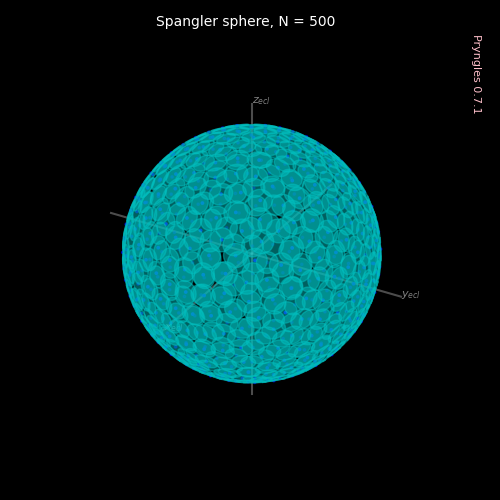

<IPython.core.display.Javascript object>


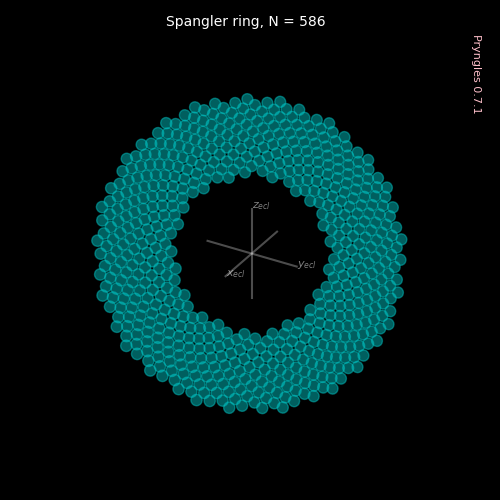

.
----------------------------------------------------------------------
Ran 1 test in 1.345s

OK


In [110]:
if IN_JUPYTER:
    def test_plot3d(self):
        Verbose.VERBOSITY=0
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        sg.plot3d(factor=1.3,c='b',s=3)
        
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1])
        sg.populate_spangler(geometry="ring",scale=2,seed=1,boundary=0)
        sg.plot3d(factor=0.4)
        #sg.populate_spangler(geometry="ring",scale=2,seed=1,gaps=[[0,0.2],[0.5,0.1]],boundary=0)
        Verbose.VERBOSITY=0

    class Test(unittest.TestCase):pass
    Test.test_plot3d=test_plot3d
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [111]:
def plot_obs(self,spangled=dict(),**args):
    """
    Plot spangle.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs=dict(c='c',s=3.5)
    sargs.update(args)
    bgcolor='k'

    #Figure
    fig=plt.figure(figsize=(5,5))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,facecolor=bgcolor)
    ax.axis("off")

    #Plot
    cond=self.data.z_obs>=0
    ax.scatter(self.data.x_obs[cond],self.data.y_obs[cond],**sargs)
    cond=self.data.z_obs<0
    sargs.update(dict(alpha=0.4))
    ax.scatter(self.data.x_obs[cond],self.data.y_obs[cond],**sargs)

    #Ranges
    maxval=1.2*np.abs(self.data[["x_obs","y_obs","z_obs"]].to_numpy()).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    
    factor=1
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],'w-',alpha=0.3)
    ax.text(xmax,0,r"$x_{obs}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,r"$y_{obs}$",color='w',alpha=0.5,fontsize=8)

    #Title
    lamb_obs=self.d_obs[1]*Consts.rad
    phi_obs=self.d_obs[2]*Consts.rad
    label_obs=f"Obs ($\lambda$,$\\beta$) : ({lamb_obs:.1f}$^\circ$,{phi_obs:.1f}$^\circ$)"
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}, {label_obs}",
                 color='w',fontsize=10,position=(0.5,+0.5),ha='center')
    Plot.pryngles_mark(ax)

    #Decoration
    #ax.set_aspect("equal")

    fig.tight_layout()
    self.fig2d=ax
    self.ax2d=ax

Spangler.plot_obs=plot_obs

<IPython.core.display.Javascript object>


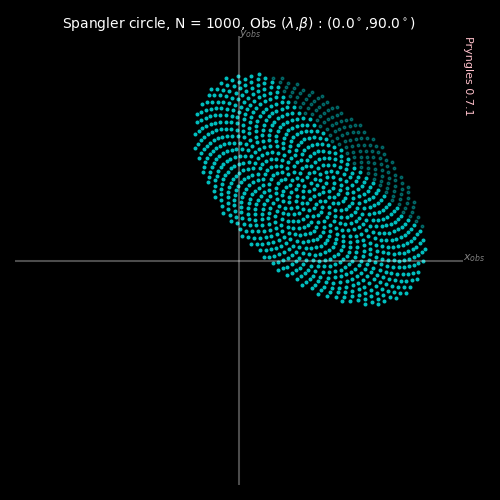

<IPython.core.display.Javascript object>


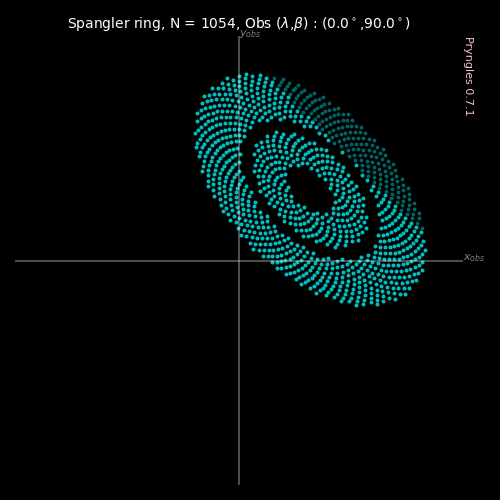

<IPython.core.display.Javascript object>


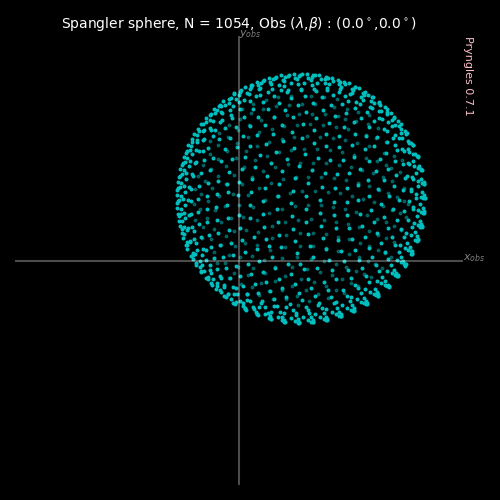

.
----------------------------------------------------------------------
Ran 1 test in 2.068s

OK


In [121]:
if IN_JUPYTER:
    def test_plotobs(self):
        Verbose.VERBOSITY=0
        sg=Spangler(nspangles=1000,body_hash="123",n_equ=[1,1,1],center=[1,1,1])
        
        sg.populate_spangler(geometry="circle",scale=2,seed=1,boundary=0)
        sg.plot_obs()

        sg.populate_spangler(geometry="ring",scale=2,seed=1,gaps=[[0,0.2],[0.5,0.1]],boundary=0)
        sg.plot_obs()
        
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        sg.set_observer(n_obs=[1,0,0])
        sg.plot_obs()

        Verbose.VERBOSITY=0

        
    class Test(unittest.TestCase):pass
    Test.test_plotobs=test_plotobs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [122]:
def _join_spanglers(self,spanglers,n_obs):
    """
    Join spanglers into a single spangler
    """
    self.spanglers=spanglers
    datas=[spangler.data for spangler in spanglers]
    self.data=pd.concat(datas,ignore_index=True)
    self.nspangles=len(self.data)
    self.geometry="Join"
    self.set_observer(n_obs)
    
Spangler._join_spanglers=_join_spanglers

<IPython.core.display.Javascript object>


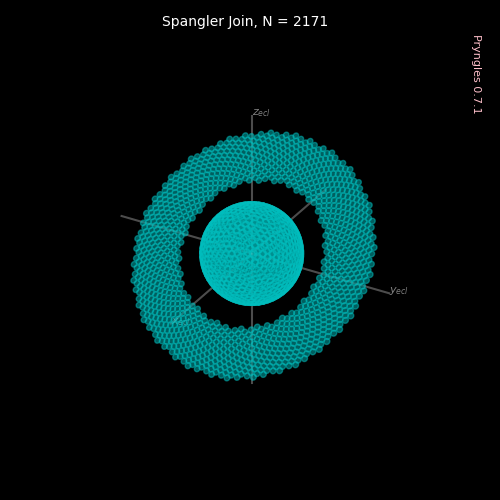

<IPython.core.display.Javascript object>


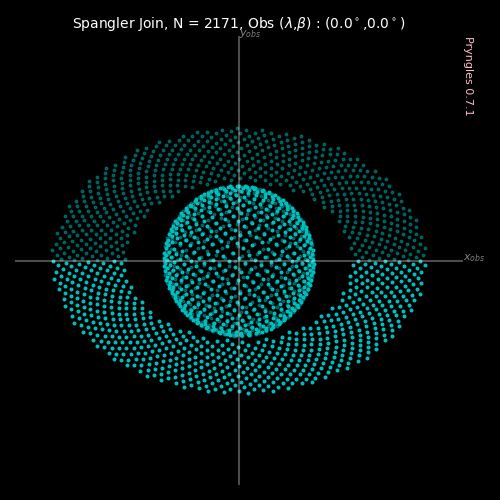

.
----------------------------------------------------------------------
Ran 1 test in 3.892s

OK


In [123]:
if IN_JUPYTER:
    def test_join(self):
        Verbose.VERBOSITY=0

        sg1=Spangler(nspangles=1000,body_hash="123",n_equ=[1,0,1])
        sg1.populate_spangler(geometry="ring",scale=2.5,seed=1,gaps=[[0,1.5/2.5]],boundary=0)

        sg2=Spangler(nspangles=1000,body_hash="345",n_equ=[0,0,1])
        sg2.populate_spangler(geometry="sphere",scale=1,seed=1)

        sgj=Spangler(spanglers=[sg1,sg2],n_obs=[1,0,0])

        sgj.plot3d()
        sgj.plot_obs()
        
        Verbose.VERBOSITY=0

    class Test(unittest.TestCase):pass
    Test.test_join=test_join
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [124]:
# Set scale
def set_scale(self,scale):
    lengths=[
        "x_equ","y_equ","z_equ",
        "x_ecl","y_ecl","z_ecl",
        "x_obs","y_obs","z_obs",
        "r_equ","r_ecl","r_obs",
        "dsp",
    ]
    self.data[lengths]*=scale
    areas=[
        "asp",
    ]
    self.data[areas]*=scale**2
    

Spangler.set_scale=set_scale

In [125]:
if IN_JUPYTER:
    def test_scale(self):
        Verbose.VERBOSITY=0

        sg=Spangler()
        print_df(sg.data)

        sg.set_scale(5)
        print_df(sg.data)

        Verbose.VERBOSITY=0

    class Test(unittest.TestCase):pass
    Test.test_scale=test_scale
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

,body_hash,type,scale,center,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,ns_ecl,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_obs,n_luz,alpha_luz,x_luz,y_luz,z_luz,r_luz,t_luz,f_luz,ns_luz,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,ns_equ,w_equ,t0_equ,T0_equ,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit
0,35503,0,1,"[0, 0, 0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,0,1.0,1.0,1,0.0,1,0,0,0,0,0,0,0


,body_hash,type,scale,center,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,ns_ecl,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_obs,n_luz,alpha_luz,x_luz,y_luz,z_luz,r_luz,t_luz,f_luz,ns_luz,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,ns_equ,w_equ,t0_equ,T0_equ,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit
0,35503,0,1,"[0, 0, 0]",0.0,0.0,5.0,5.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,0.0,0.0,5.0,5.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0, 0, 1]",0,0,0,0,0,0,0,"[0, 0, 0]","[0.0, 0.0, 1.0]",0,0,0,5,0,0,1.570796,"[0, 0, 1]",0,0,0,25.0,5.0,1,0.0,1,0,0,0,0,0,0,0


.
----------------------------------------------------------------------
Ran 1 test in 0.039s

OK


--End--

### Documentation

- https://stackoverflow.com/questions/63977848/assign-multiple-columns-of-numpy-to-one-pandas-dataframe-column